<a href="https://colab.research.google.com/github/bmreiniger/datascience.stackexchange/blob/master/58631_prob_calib_class_weights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

In [2]:
prop_class_1 = 0.01
X, y = make_classification(n_samples=100000, weights=[1-prop_class_1, prop_class_1],
                           n_features=20, n_informative=10,
                           random_state=314)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)
lr = LogisticRegression(class_weight={0: 1/(1-prop_class_1), 1: 1/prop_class_1})
lr.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight={0: 1.0101010101010102, 1: 100.0},
                   dual=False, fit_intercept=True, intercept_scaling=1,
                   l1_ratio=None, max_iter=100, multi_class='warn', n_jobs=None,
                   penalty='l2', random_state=None, solver='warn', tol=0.0001,
                   verbose=0, warm_start=False)

In [3]:
y_pred = lr.predict_proba(X_test)[:,1]
print(y_pred.mean())
print(y_test.mean())

0.49542420945640725
0.01516


As expected, the model trained with class weights for balance produces balanced predictions.

In [0]:
y_pred_odds = 1/((1/y_pred)-1)
y_adj_odds = y_pred_odds * (prop_class_1 / (1-prop_class_1))
y_adj_probs = 1/ (1+ 1/y_adj_odds)

In [5]:
print(y_adj_probs.mean())

0.014732435648352507


The proposed adjustment have brought the predictions back into the range of the original population.

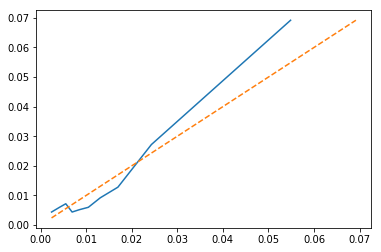

In [6]:
plot_true, plot_pred = calibration_curve(y_test, y_adj_probs, strategy='quantile', n_bins=10)
plt.plot(plot_pred, plot_true)
xmin = min(plot_pred.min(), plot_true.min())
xmax = max(plot_pred.max(), plot_true.max())
plt.plot([xmin,xmax],[xmin,xmax], '--')
plt.show()

Calibration looks pretty good.


---

Finally, let's try without the class weights:


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


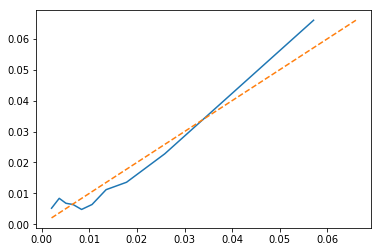

In [7]:
lr2 = LogisticRegression()
lr2.fit(X_train, y_train)
y_pred2 = lr2.predict_proba(X_test)[:,1]
plot_true, plot_pred = calibration_curve(y_test, y_pred2, strategy='quantile', n_bins=10)
plt.plot(plot_pred, plot_true)
xmin = min(plot_pred.min(), plot_true.min())
xmax = max(plot_pred.max(), plot_true.max())
plt.plot([xmin,xmax],[xmin,xmax], '--')
plt.show()

---

Bonus content (should be explored more): how do the weighted and unweighted models compare???


In [8]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_test, y_pred))
print(roc_auc_score(y_test, y_pred2))


0.7653556143322746
0.7443578154050231


The unweighted model does pretty well too!

In [9]:
from sklearn.metrics import average_precision_score
print(average_precision_score(y_test, y_pred))
print(average_precision_score(y_test, y_pred2))

0.058349810410396996
0.08588902072602063


In [21]:
from sklearn.metrics import precision_score
threshold = 0.5
thresh_odds = 1/(1/threshold-1)
adj_odds = thresh_odds * prop_class_1/(1-prop_class_1)
adj_thresh = 1/(1+1/adj_odds)
print(precision_score(y_test, lr.predict(X_test)))
print(precision_score(y_test, y_pred>threshold))
print(precision_score(y_test, y_pred2>adj_thresh))

0.026106119681301915
0.026106119681301915
0.025126903553299492
